In [1]:
from keras.datasets import cifar10, mnist, fashion_mnist
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Input, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras import optimizers
import keras
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
x_train, x_val = x_train.astype('float32')/255.,  x_val.astype('float32')/255.
y_train, y_val = to_categorical(y_train), to_categorical(y_val)

In [4]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect',
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [5]:
train_datagen.fit(x_train)

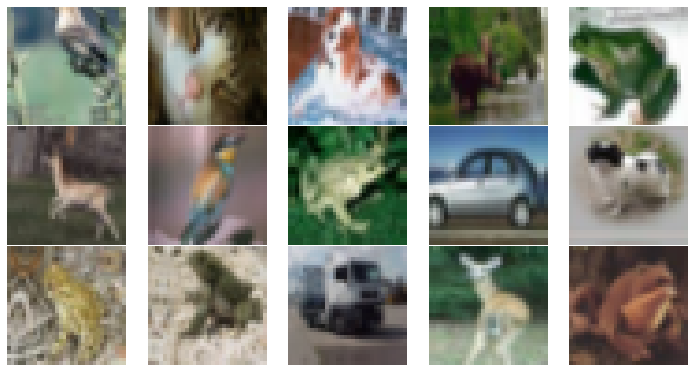

In [6]:
plt.figure(figsize=(10,5))

for X_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=15):
    for i in range(0, 15):
        plt.subplot(3, 5, i+1)
        plt.imshow(X_batch[i].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout(pad=0.1)
    plt.show()
    break

In [7]:
model = Sequential()
model.add(Conv2D(64,(3,3), activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
bs = 64
epochs = 15

In [9]:
history = model.fit_generator(train_datagen.flow(x_train, y_train,
                              batch_size=bs),
                              epochs=epochs,
                              steps_per_epoch=len(x_train)/bs,
                              validation_data=(x_val, y_val))

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


781/781 [==============================] - 48s 50ms/step - loss: 1.6558 - accuracy: 0.3946 - val_loss: 1.2810 - val_accuracy: 0.5376
Epoch 2/15
781/781 [==============================] - 38s 49ms/step - loss: 1.3143 - accuracy: 0.5288 - val_loss: 1.0441 - val_accuracy: 0.6318
Epoch 3/15
781/781 [==============================] - 37s 47ms/step - loss: 1.1577 - accuracy: 0.5886 - val_loss: 1.0360 - val_accuracy: 0.6483
Epoch 4/15
781/781 [==============================] - 34s 44ms/step - loss: 1.0682 - accuracy: 0.6228 - val_loss: 0.9089 - val_accuracy: 0.6740
Epoch 5/15
781/781 [==============================] - 35s 44ms/step - loss: 1.0097 - accuracy: 0.6462 - val_loss: 0.8342 - val_accuracy: 0.7061
Epoch 6/15
781/781 [==============================] - 35s 45ms/step - loss: 0.9569 - accuracy: 0.6646 - val_loss: 0.8262 - val_accuracy: 0.7158
Epoch 7/15
781/781 [==============================] - 38s 48ms/step - loss: 0.9297 - accuracy: 0.6757 - val_loss: 0.8110 - val_accuracy: 0.7215
Epo

In [10]:
print(f'Baseline accuracy: {model.evaluate(x_val, y_val)[1]}')

313/313 [==============================] - 2s 5ms/step - loss: 0.7291 - accuracy: 0.7557
Baseline accuracy: 0.7556999921798706


### Define the test Image Generator

In [11]:
tta_steps = 10

In [12]:
test_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [13]:
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(test_datagen.flow(x_val, batch_size=bs, shuffle=False), steps = len(x_val)/bs)
    predictions.append(preds)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.
100%|██████████| 10/10 [00:52<00:00,  5.25s/it]


In [14]:
final_pred = np.mean(predictions, axis=0)

In [15]:
print(f'Accuracy with TTA: {np.mean(np.equal(np.argmax(y_val, axis=-1), np.argmax(final_pred, axis=-1)))}')

Accuracy with TTA: 0.7804


### See the impact of TTA on a single image

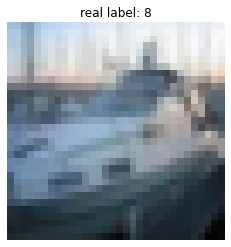

In [16]:
image_ix = 2
test_image = x_val[image_ix]
plt.imshow(test_image)
plt.title(f'real label: {np.argmax(y_val[image_ix])}')
plt.axis('off');

1/1 [==============================] - 0s 16ms/step


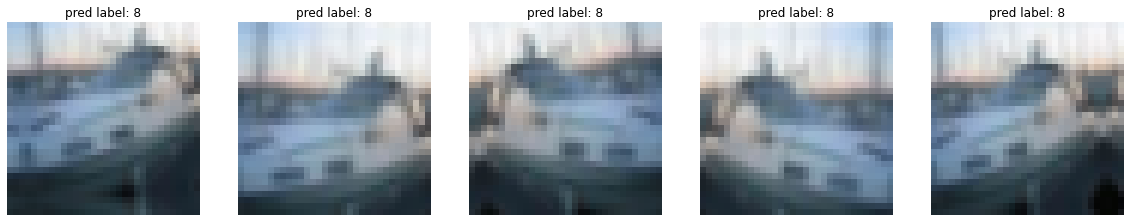

In [17]:
plt.figure(figsize=(20,14))
predictions = []

for i in range(5):
    im = test_datagen.flow(test_image.reshape(1,32,32,3), batch_size=1, shuffle=False)
    im = next(im)
    pred = model.predict(im.reshape(1,32,32,3))
    predictions.append(pred)
    plt.subplot(1, 5, i+1)
    plt.title(f'pred label: {np.argmax(pred)}')
    plt.imshow(im.reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

In [28]:
final_pred = np.mean(predictions, axis=0)
print(f'final pred: {np.argmax(final_pred)}')

final pred: 8
